### Clustering ###

In [1]:
from matplotlib.image import imread
image = imread(r"C:\Users\royha\Documents\Uni\SimData\cats-vs-dogs\clustering test\21.jpg")
image.shape

(404, 360)

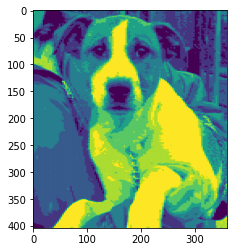

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

imgplot = plt.imshow(segmented_img)

In [3]:
segmented_img

array([[137.36355914, 137.45933319, 136.63368019, ...,  83.20812472,
         83.0994538 ,  83.51456532],
       [137.36355914, 137.45933319, 136.63368019, ...,  83.20812472,
         83.0994538 ,  83.51456532],
       [137.36355914, 137.45933319, 136.63368019, ...,  83.20812472,
         83.0994538 ,  83.51456532],
       ...,
       [ 30.58866769,  29.76661562,  30.71485452, ..., 193.8700218 ,
        194.65068357, 193.86566277],
       [ 30.58866769,  29.76661562,  30.71485452, ..., 193.8700218 ,
        194.65068357, 193.86566277],
       [ 30.58866769,  29.76661562,  30.71485452, ..., 193.8700218 ,
        194.65068357, 193.86566277]])

## Preparing the Data ##

In [4]:
from sklearn.model_selection import train_test_split
import os, cv2
import numpy as np

# dog = 0, cat = 1
def LoadAnimals(directory, clustering=0):
    x = []
    y = []

    for filename in os.listdir(directory):
        if 'dog' in filename:
            animal_class = 0
        else: # cat
            animal_class = 1

        f = os.path.join(directory, filename)
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)

        if clustering != 0:
            reshaped_image = image.reshape(-1, 3)
            kmeans = KMeans(n_clusters=clustering).fit(reshaped_image)
            segmented_img = kmeans.cluster_centers_[kmeans.labels_]
            segmented_img = segmented_img.reshape(image.shape)
            image = segmented_img

        x.append(np.concatenate(image)) # sklearn doesn't like 3d arrays (x_train is an array of 2d arrays -> 3d array). Transforms 3d array to 2d.
        y.append(animal_class)

    return x, y

In [5]:
x, y = LoadAnimals(r"C:\Users\royha\Documents\Uni\SimData\cats-vs-dogs\clusters", clustering=0)

## Analyzing Feature Importance ##
Using Random Forest.

In [6]:
def array1dto2d(arr, w, h):
    if w*h != len(arr):
        return None
    else:
        ret = []
        for i in range(0, h):
            ret.append( arr[w*i:w*(i+1)] )
        return ret

In [26]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib.colors import ListedColormap

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(x, y)

impprtances = array1dto2d(rnd_clf.feature_importances_, 360, 404)

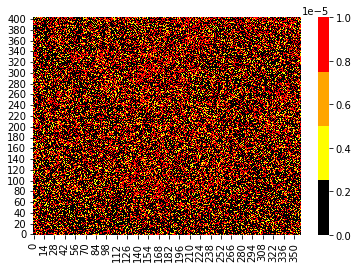

In [31]:
sns.heatmap(impprtances, vmin=0, vmax=0.00001, cmap=ListedColormap(['black', 'yellow', 'orange', 'red']))
plt.xlim(0, 360)
plt.ylim(0, 404)
plt.show()

Conclusion: It seems our pictures don't have a pattern and a specific area in which the important (or non-important, a dead space such the top right corner commonly being a wall) information is.

# Models #

In [6]:
from sklearn.model_selection import cross_val_score

def Test(name, model):
    score = abs(np.median( cross_val_score(model, x, y, cv=10, scoring='accuracy') ))
    print('{}: {}'.format(name, score))

First we will run a dummy to set our baseline.

In [8]:
from sklearn.dummy import DummyClassifier
Test('Dummy (stratified)', DummyClassifier(strategy="stratified"))
Test('Dummy (most_frequent)', DummyClassifier(strategy="most_frequent"))

Dummy (stratified): 0.48
Dummy (most_frequent): 0.5


Next we will try out Logistic Regression (without high hopes).

In [9]:
from sklearn.linear_model import LogisticRegression
Test('Logistic Regression', LogisticRegression())

c:\Users\royha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\royha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Logistic Regression: 0.495


c:\Users\royha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
from sklearn.ensemble import RandomForestClassifier
Test('Random Forest', RandomForestClassifier())

Random Forest: 0.6


Lets try some new models: AdaBoost, XGBoost.

In [11]:
from xgboost import XGBClassifier
Test('XGBoost', XGBClassifier())

XGBoost: 0.605


In [12]:
from sklearn.ensemble import AdaBoostClassifier
Test('AdaBoost', AdaBoostClassifier())

AdaBoost: 0.535


Now lets run our models together using Bagging.